# Estimator Representations

This script's purpose is to generate really clean estimator figures in a simple framework. We are only using curve fit with an initial value in the appropriate parameter space to estimate all pixels of the brain. The model used is the biexponential model with an offset term added. Normalization is not done beforehand but is done afterwards.

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import statistics
import math
import time
import itertools
from tqdm import trange
from datetime import date
import pickle
import pandas as pd
import sys
import os

In [2]:
brain_data = scipy.io.loadmat(os.getcwd() + '/MB_References/BLSA_1742_04_MCIAD_m41/NESMA_slice5.mat')
I_raw = brain_data['slice_oi']

n_vert, n_hori, n_elements = I_raw.shape

t_increment_brain = 11.3 #This is a measurement originally indicated by Chuan Bi in the initial email about this data
tdata = np.linspace(t_increment_brain, (n_elements)*(t_increment_brain), n_elements)

#All pixels with a lower mask amplitude are considered to be free water (i.e. vesicles)
mask_amplitude = 740

#This is important for regularization if this is deemed necessary here
ob_weight = 100

MB_model = False

init_p = (0.2, 0.8, 20, 80, 1)
lb = [0,0,0,0,0]
ub = [np.inf,np.inf, 60, 300, np.inf]

vert1 = 165
vert2 = 180
hori1 = 120
hori2 = 180

vBox = (vert1,vert1,vert2,vert2,vert1)
hBox = (hori1,hori2,hori2,hori1,hori1)

noiseRegion = [vert1,vert2,hori1,hori2]

In [3]:
############# Signal Functions ##############

def G_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    function = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return function

def G_MB(t, amp, con_1, tau_1, tau_2, offSet):
    function = amp*(con_1*np.exp(-t/tau_1) + (1-con_1)*np.exp(-t/tau_2)) + offSet
    return function

#This is used with regularization
def G_tilde(lam, SA = 1, opt_MB = MB_model):
    #SA defines the signal amplitude, defaults to 1 for simulated data
    if opt_MB:
        def Gt_lam(t, amp, con1, tau1, tau2, oS):
            return np.append(G_MB(t, amp, con1, tau1, tau2, oS), [lam*con1/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    else:
       def Gt_lam(t, con1, con2, tau1, tau2, oS):
            return np.append(G_off(t, con1, con2, tau1, tau2, oS), [lam*con1/SA, lam*con2/SA, lam*tau1/ob_weight, lam*tau2/ob_weight])
    return Gt_lam

In [4]:
def mask_data(raw, mask_amplitude):
    #Sets every decay curve in the data set where the amplitude is less than a threshold value to zero
    I_masked = np.copy(raw)
    I_masked[I_masked[:,:,0]<mask_amplitude] = 0
    return I_masked

def get_brain_outline(raw):
    I_outline = np.zeros((n_hori,n_vert))
    for i_vert in range(n_vert):
        for i_hori in range(n_vert):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                init_sig_up = raw[i_vert-1, i_hori, 0]
                init_sig_lt = raw[i_vert, i_hori-1, 0]
                init_sig_rt = raw[i_vert, i_hori+1, 0]
                init_sig_dn = raw[i_vert+1, i_hori, 0]
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = 0
    return I_outline

def calculate_brain_SNR(raw, region):
    #calculates the SNR of the brain using a homogenous region fed into the 
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    regionZero_mean = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:] #last three points across the entire sampled region
    regionEnd_std = np.std(regionEnd)
    regionEnd_absMean = np.mean(np.abs(regionEnd))

    SNR_region = (regionZero_mean - regionEnd_absMean)/regionEnd_std

    return SNR_region

def add_noise_brain_uniform(raw, SNR_desired, region):
    #This function was built with the intention of taking a region (e.g. the homogenous region to the right of the ventricles)
    #Add noise to make sure the final SNR is close to the desired SNR

    I_mask_factor = (raw!=0)
    v1,v2,h1,h2 = region

    rawZone = raw[v1:v2,h1:h2,:]

    regionZero = rawZone[:, :, 0]
    sigRef = np.mean(regionZero)

    regionEnd = rawZone[:, :, -3:]
    initSD = np.std(regionEnd)

    addSD = (sigRef**2/SNR_desired**2 - initSD**2)**(1/2)

    noiseMat = np.random.normal(0,addSD,raw.shape)
    I_noised = raw + noiseMat*I_mask_factor

    return I_noised, addSD

def add_noise(raw, addSD):
    I_mask_factor = (raw!=0)
    noiseMat = np.random.normal(0,addSD,raw.shape)
    I_noised = raw + noiseMat*I_mask_factor
    return I_noised

def check_param_order(popt):
    #Function to automate the order of parameters if desired
    #Reshaping of array to ensure that the parameter pairs all end up in the appropriate place - ensures that T22 > T21
    if (popt[2] > popt[3]): #We want by convention to make sure that T21 is <= T22
        p_hold = popt[0]
        popt[0] = popt[1]
        popt[1] = p_hold

        p_hold = popt[2]
        popt[2] = popt[3]
        popt[3] = p_hold
    return popt

def estimate_parameters(function, tdata, data, init_p, lb, ub):

    popt, pcov = curve_fit(function, tdata, data, bounds = (lb, ub), p0=init_p, maxfev = 4000)
    if not MB_model:
        popt = check_param_order(popt)
    else:
        popt = popt
        
    return popt

def post_normalize(object):
    initial_shape = object.shape
    stacked_params = np.reshape(object, (-1,5))
    scaled_params = np.ones(stacked_params.shape)*np.NAN
    coeficients = stacked_params[:,0]+stacked_params[:,1]
    coeficients = np.where(coeficients == 0, 1-coeficients, coeficients) #to avoid dividing by zero
    scaled_params[:,0:2] = stacked_params[:,0:2]/coeficients[:,None]
    scaled_params[:,2:] = stacked_params[:,2:]
    final_obj = np.reshape(scaled_params, initial_shape)
    return final_obj

In [5]:
I_data = mask_data(I_raw, mask_amplitude)

NLLS_estimates = np.zeros((n_vert, n_hori, 5))

#This should take about 6 minutes for a 288 by 288 pixel image for 32 echos
for i_vert in trange(n_vert):
    for i_hori in range(n_hori):

        noise_data = I_data[i_vert, i_hori, :]
    
        if np.all(noise_data == 0):
            param_estimates = [0,0,1,1,0]
        else:
            #Have to adjust the initial parameter values since there is no pre-normalization
            temp_p0 = np.copy(init_p)
            temp_p0[0] = temp_p0[0]*noise_data[0]
            temp_p0[1] = temp_p0[1]*noise_data[0]
            param_estimates = estimate_parameters(G_off, tdata, noise_data, init_p, lb, ub)
        
        NLLS_estimates[i_vert, i_hori, :] = param_estimates

100%|██████████| 288/288 [06:48<00:00,  1.42s/it]


In [6]:
high_bias_estimates = get_brain_outline(I_data)
high_bias_estimates_opt2 = (I_data[:,:,0]>0)

In [7]:
seed_choice = 1
np.random.seed(seed_choice)

#This option corresponds to estimating the parameters from a noisey signal (a fresh start) or using
#the parameters already determined and adding noise to this
option_freshStart = False

high_var_estimates = np.zeros((n_vert, n_hori, 5))

if option_freshStart:
    I_noised = add_noise_brain_uniform(I_data, 100, noiseRegion)[0]
    print(f'Pre-brian SNR approx = {calculate_brain_SNR(I_data, noiseRegion) :0.2f} :: Post-brain SNR approx = {calculate_brain_SNR(I_noised, noiseRegion) :0.2f}')

    

    max_fits = []

    #This should take about 6 minutes for a 288 by 288 pixel image for 32 echos
    for i_vert in trange(n_vert):
        for i_hori in range(n_hori):

            noise_data = I_noised[i_vert, i_hori, :]
        
            if np.all(noise_data == 0):
                param_estimates = [0,0,1,1,0]
            else:
                #Have to adjust the initial parameter values since there is no pre-normalization
                temp_p0 = np.copy(init_p)
                temp_p0[0] = temp_p0[0]*noise_data[0]
                temp_p0[1] = temp_p0[1]*noise_data[0]
                try:
                    param_estimates = estimate_parameters(G_off, tdata, noise_data, init_p, lb, ub)
                except Exception as error:
                    popt = [0,0,1,1,0]
                    print(f'Error at {i_vert} and {i_hori}:' + str(error))
                    max_fits.append([i_vert, i_hori])
            
            high_var_estimates[i_vert, i_hori, :] = param_estimates
    

In [8]:
NLLS_estimates_pn = post_normalize(NLLS_estimates)
if option_freshStart:
    high_var_estimates_pn = post_normalize(high_var_estimates)
else:
    high_var_estimates_pn = np.zeros((n_vert, n_hori, 5))
    high_var_estimates_pn[:,:, 0] = add_noise(NLLS_estimates_pn[:,:, 0], 0.3)

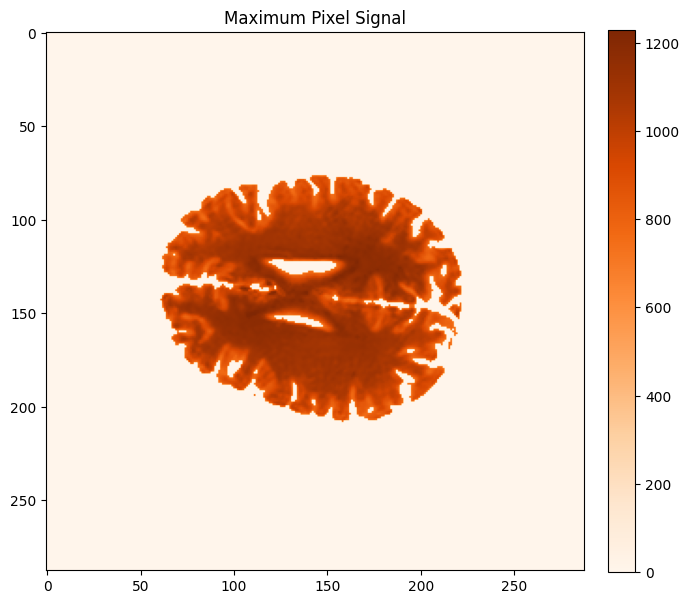

In [9]:
fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(7,9))
imc1 = ax.imshow(np.max(I_data[:, :, :], axis = -1), cmap = 'Oranges', vmin = 0)
ax.set_title("Maximum Pixel Signal")
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.show()

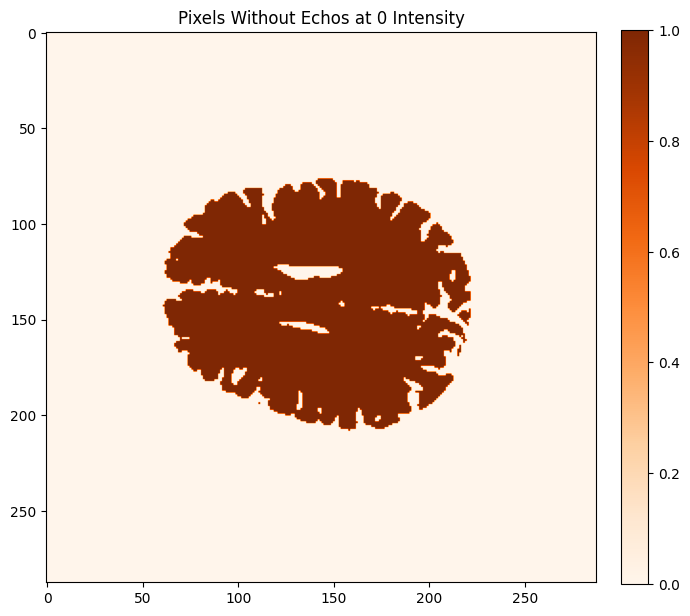

In [10]:
fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(7,9))
imc1 = ax.imshow(np.min(I_data[:, :, :], axis = -1)!=0, cmap = 'Oranges', vmin = 0)
ax.set_title("Pixels Without Echos at 0 Intensity")
fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)

plt.show()

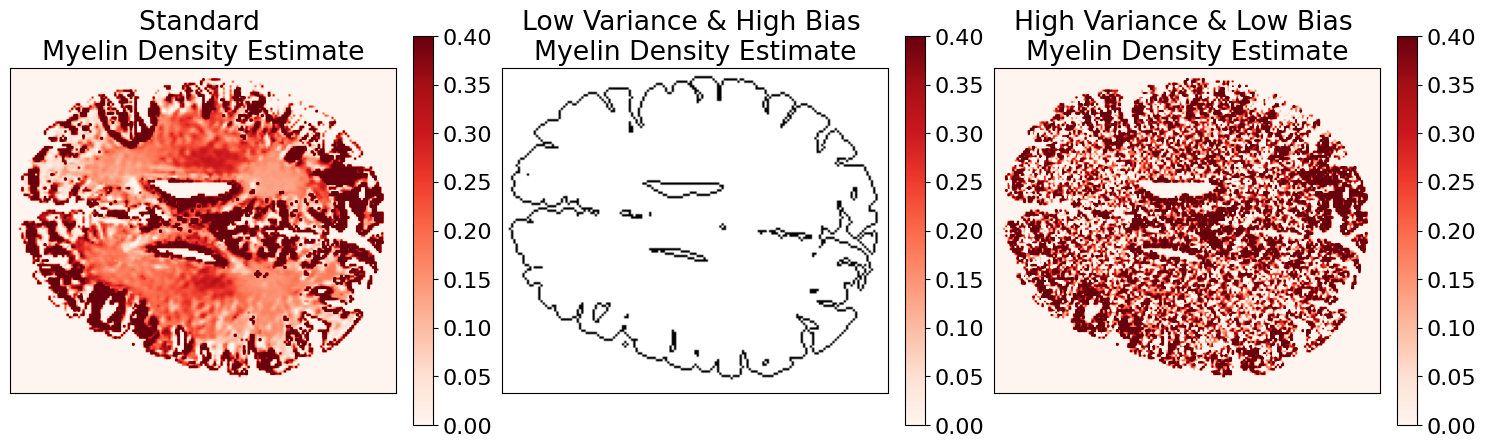

In [11]:
fig, ax = plt.subplots(1,3,figsize=(15,6), tight_layout=True)
# fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

v_hi = n_vert//4*3
v_lo = n_vert//4

h_hi = n_hori//5*4
h_lo = n_hori//5

plt.rc('font', size = 16)

imc1 = ax[0].imshow(NLLS_estimates_pn[v_lo:v_hi, h_lo:h_hi, 0], cmap = 'Reds', vmin=0, vmax = 0.4)
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title("Standard \nMyelin Density Estimate")
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

imc2 = ax[1].imshow(1-high_bias_estimates[v_lo:v_hi, h_lo:h_hi], cmap = 'gray', vmin=0, vmax = 1)
fig.colorbar(imc1, ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title("Low Variance & High Bias \nMyelin Density Estimate")
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
# fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04)

imc3 = ax[2].imshow(high_var_estimates_pn[v_lo:v_hi, h_lo:h_hi,0], cmap = 'Reds', vmin=0, vmax = 0.4)
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_title("High Variance & Low Bias \nMyelin Density Estimate")
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.show()

In [13]:
if option_freshStart:
    fig, ax = plt.subplots(1,1,figsize=(8,6), tight_layout=True)
    # fig.suptitle('Null Point Neighbhorhood Bayes Information Criterion')

    array_fits = np.zeros((len(max_fits),2))
    for i in range(len(max_fits)):
        array_fits[i,0] = max_fits[i][0]
        array_fits[i,1] = max_fits[i][1]

    plt.rc('font', size = 16)

    imc1 = ax.imshow(NLLS_estimates_pn[:,:, 0]>0, cmap = 'Reds', vmin=0, vmax = 1.2)
    ax.plot(array_fits[:,1],array_fits[:,0], marker = 'o', ls = '', color = 'k', markersize = 3)
    # fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04)
    ax.set_title("Issue with Curve Fit Parameter Fitting")
    ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

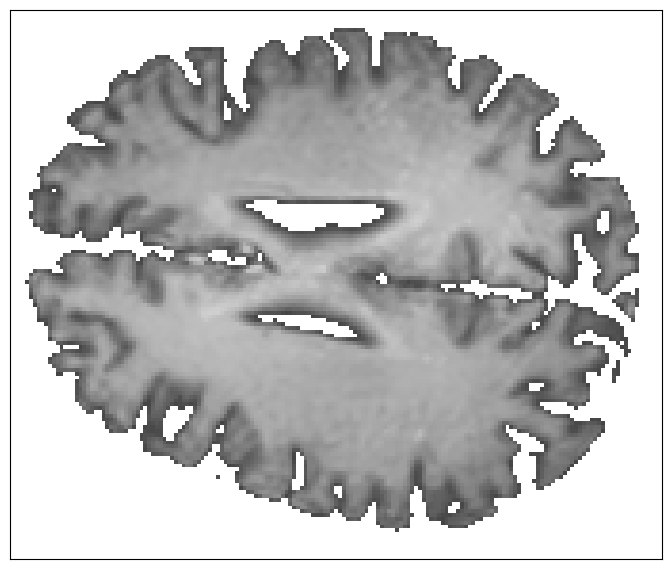

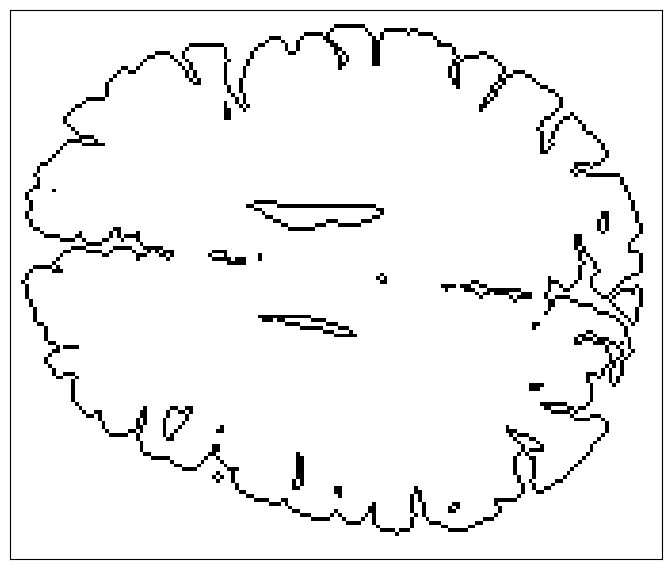

In [37]:
BrainFig = I_data[:,:,0]
topVal = 1400
BrainFig[np.where(BrainFig == 0)] = topVal

fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(7,9), frameon = False)
imc1 = ax.imshow(BrainFig[v_lo:v_hi, h_lo:h_hi], cmap = 'gray', vmin = 500, vmax = topVal)
# ax.set_title("Maximum Pixel Signal")
# fig.colorbar(imc1, ax=ax, fraction=0.046, pad=0.04)
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
plt.savefig('T2_weightedBrain.png',bbox_inches='tight',transparent=True, pad_inches=0)

plt.show()

fig, ax = plt.subplots(1,1, tight_layout=True, figsize=(7,9), frameon = False)
imc1 = ax.imshow(1-high_bias_estimates[v_lo:v_hi, h_lo:h_hi], cmap = 'gray', vmin=0, vmax = 1)
# fig.colorbar(imc1, ax=ax[1], fraction=0.046, pad=0.04)
# ax.set_title("Low Variance & High Bias \nMyelin Density Estimate")
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
plt.savefig('BrainOutline.png',bbox_inches='tight',transparent=True, pad_inches=0)